In [1]:
import numpy as np
from scipy.io import loadmat, wavfile
import os
import matplotlib.pyplot as plt
%matplotlib inline
from librosa import istft
from scipy.signal import resample, resample_poly
from resampy import resample as resample2
import copy
import random
import IPython.display as ipd
import json
from sklearn import linear_model
import pickle as pkl
import time
from sklearn.linear_model import LinearRegression

from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from data_utils import norm_power_wav, envelope, unit_power, true_SNR, daniel_env, load_wav
import torch
import data_utils

from sep_eval import sep_eval
from model_stft import InfoComMask
import torch 
from train_test import sSDR

import seaborn as sns
import librosa

import pandas as pd
import sys
from tqdm import tqdm
import statannot 

In [2]:
def load_info_model(load, base_dir='/Data/Dropbox/PhD/Projects/brain-informed-source-separation'):
    json_dir = base_dir + '/logs2/' + load
    with open(json_dir + '/architecture.json', 'r') as fff:
        p = json.load(fff)
        load_path = json_dir

        model = InfoComMask(n_fft=p['nfft'], kernel=(p['kf'], p['kt']), causal=p['causal'],
                                layers=p['layers'], stacks=p['stacks'], verbose=False)

        model.load_state_dict(torch.load(load_path + '/model_weights.pt'))
        _ = model.eval()
        return model, p

In [8]:
# _model, _p = load_info_model('201908204652_ICM_noise_35_28_dan_125_sep_C')
_model, _p = load_info_model('201909022406_ICM_noise_15_12_dan_125_bab_NC')

In [ ]:
data_s8 = loadmat('./eeg_data/DATA_preproc/S8_data_preproc.mat')
eeg = data_s8['data'][0][0][3].squeeze()
print(eeg[0].shape)
wav_att = data_s8['data'][0][0][5].squeeze()
print(wav_att[0].shape)
wav_unatt = data_s8['data'][0][0][6].squeeze()
print(wav_unatt[0].shape)

In [ ]:
# verbose
data_dir = '/Data/DATASETS/WSJ/'
code_dir = '/Data/Dropbox/PhD/Projects/'
base_dir = code_dir + 'brain-informed-source-separation'
validation_data_path = data_dir + 'danish_english_singles_v4.h5'  # datadir  # change this!
data_verbose = data_utils.DatasetSTFTv5(validation_data_path,  task='valid', env='dan')

mix = []
s1 = []
env = []

for i in range(1):
    mix_tensor, s1_tensor, h_tensor = data_verbose[i]
    mix.append(mix_tensor.unsqueeze(0))
    s1.append(s1_tensor.unsqueeze(0))
    env.append(h_tensor.unsqueeze(0))
    
mix = torch.cat(mix, 0)
s1 = torch.cat(s1, 0)
env = torch.cat(env, 0)
print(mix.shape)
print(env.shape)

recon = _model([mix, env])
print(recon.shape)
print(sep_eval.sdr(recon.squeeze().data.numpy(), s1.squeeze().data.numpy(), average=False))

In [ ]:
TRIAL = 13
TRIAL_LEN = 4  # in s
EEG_FS = 64import statannot 
AUDIO_FS = 8000
hop = 125
max_len = TRIAL_LEN * AUDIO_FS
audio_dir = './eeg_data/AUDIO/'
# load EEG
eeg_trial = torch.from_numpy(eeg[TRIAL][:TRIAL_LEN * EEG_FS + 1].T.astype('float32')).unsqueeze(0)
env_trial = wav_att[TRIAL][:TRIAL_LEN * EEG_FS + 1].T.astype('float32')
# load audios
info = pd.read_csv('./corr_nets/S8info.csv')
info = info[info["n_speakers"] == 2]
frame = info.iloc[TRIAL]
mal, _ = librosa.load(audio_dir + frame.wavfile_male, sr=AUDIO_FS)
fem, _ = librosa.load(audio_dir + frame.wavfile_female, sr=AUDIO_FS)

if frame.attend_mf == 1:
    att = mal
    unatt = fem
else:
    att = fem
    unatt = mal

att = att[:max_len]
unatt = unatt[:max_len]

y = [true_SNR(_y, verbose=True, snr_range=(0, 0)) for _y in [att, unatt]]
mx = np.sum(np.array(y), axis=0)
mixture = norm_power_wav(mx)

mix_trial = torch.from_numpy(mixture.astype('float32')).unsqueeze(0)

raw_gt = y[1]
raw_gt /= np.sqrt(np.mean((raw_gt - np.mean(raw_gt)) ** 2)) + 1e-15
raw_gt *= 0.025
raw_gt = daniel_env(raw_gt)

if len(raw_gt) < max_len // hop + 1:
    raw_gt = np.concatenate([raw_gt, np.zeros((max_len // hop + 1 - len(raw_gt),))])

raw_gt = norm_power_wav(raw_gt)
    
my_env = torch.from_numpy(raw_gt.astype('float32')).unsqueeze(0)

print(eeg_trial.shape)
print(my_env.shape)
print(mix_trial.shape)

In [ ]:
recon = _model([mix_trial, eeg_trial])
print(recon.shape)
ipd.display(ipd.Audio(recon[0].squeeze().data.numpy(), rate=8000))
ipd.display(ipd.Audio(mix_trial[0].squeeze().data.numpy(), rate=8000))
ipd.display(ipd.Audio(att, rate=8000))
print(sep_eval.sdr(recon[0].squeeze().data.numpy(), att[:-1]))

In [ ]:
recon = _model([mix_trial, my_env * 1])
print(recon.shape)
ipd.display(ipd.Audio(recon[0].squeeze().data.numpy(), rate=8000))
ipd.display(ipd.Audio(mix_trial[0].squeeze().data.numpy(), rate=8000))
ipd.display(ipd.Audio(att, rate=8000))
print(sep_eval.sdr(recon[0].squeeze().data.numpy(), unatt))

# Speech vs Noise

In [3]:
data_dir = './nback_analysis/'
recon_dir = '_recons'
audio_dir = '_audio/Lists'

In [4]:
idx = 10
y, fs = librosa.load(f"{data_dir}/{audio_dir}/list{idx}.wav", sr=8000)
ipd.display(ipd.Audio(y, rate=fs))

In [5]:
subs = os.listdir(os.path.join(data_dir, recon_dir))
n_subs = len(subs)
data_sub = loadmat(os.path.join(data_dir, recon_dir, subs[2]))
print(data_sub.keys())

dict_keys(['__header__', '__version__', '__globals__', 'W', 'clean_env', 'corrvalues', 'lambda', 'mustd_env', 'recon', 'trialinfo'])


In [37]:
trial_info = data_sub['trialinfo'].T
print(trial_info.shape)
n_trials = trial_info.shape[0]

# they are in 128 Hz
recon_env = np.concatenate(data_sub['recon'].squeeze(), 1)
true_env = np.concatenate(data_sub['clean_env'].squeeze(), 0).T

# resample to 64 Hz
recon_env_res = resample_poly(recon_env, 1, 2).T
true_env_res = resample_poly(true_env, 1, 2).T

print(recon_env_res.shape)
print(true_env_res.shape)

(36, 2)
(36, 2753)
(36, 2753)


Noise: MEAN=-2.3658948097109524e-18 | STD=0.4047005939244227


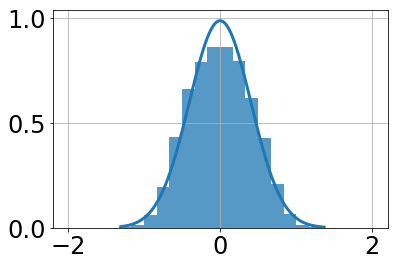

In [46]:
bins = np.linspace(-2, 2, 25)
data = norm_power_wav(recon_env_res.reshape(-1)) - norm_power_wav(true_env_res.reshape(-1))
mean, std=norm.fit(data)
plt.hist(data, bins, density=True, alpha=0.75, color='tab:blue', label='Clean')
xmin, xmax = np.min(data), np.max(data)
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean, std)
print(f"Noise: MEAN={mean} | STD={std}")
plt.plot(x, y, color='tab:blue', linewidth=3)
plt.grid()
# plt.annotate(f"{mean:.3}", xy=(-2, 0.75), color='tab:blue',  xycoords='data', ha='center')
# plt.annotate(f"{std:.3}", xy=(-1.5, 0.5), color='tab:blue',  xycoords='data', ha='center')

In [47]:
np.save('residual_eeg', data)

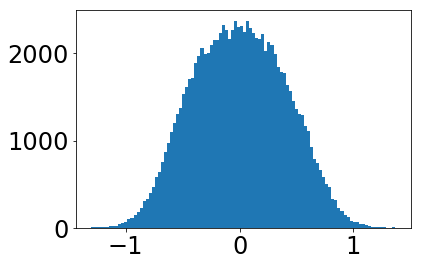

In [39]:
_ = plt.hist(norm_power_wav(recon_env_res.reshape(-1)) - norm_power_wav(true_env_res.reshape(-1)), 100)

In [9]:
trial = 28
n_samples = 5
batch_size = 1


all_trials_sdr = []
all_trials_ori_sdr = []
all_trials_corrs = []

# loading audio
y_noisy, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}.wav", sr=8000)
y_clean, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}_clean.wav", sr=8000)
y_noise, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}_noise.wav", sr=8000)

# mix high/low snr
if trial_info[trial, 0] > 2:
    mix = true_SNR(y_clean[2 * fs:45 * fs], snr_range=(0, 0)) + true_SNR(y_noise[2 * fs:45 * fs], snr_range=(10, 10))
else:
    mix = true_SNR(y_clean[2 * fs:45 * fs], snr_range=(0, 0)) + true_SNR(y_noise[2 * fs:45 * fs], snr_range=(0, 0))

s1 = y_clean[2 * fs:45 * fs]

s1 = s1[:n_samples * 8 * fs].reshape(-1, 64000)
mix = norm_power_wav(mix)[:n_samples * 8 * fs].reshape(-1, 64000)

recon_env = norm_power_wav(recon_env_res[trial])[:n_samples * 512].reshape(-1, 512)
true_env = norm_power_wav(true_env_res[trial])[:n_samples * 512].reshape(-1, 512)
env = np.hstack([recon_env, np.zeros((n_samples, 1))])

print(s1.shape)
print(mix.shape)
print(env.shape)

mix = torch.from_numpy(mix.astype('float32'))
env = torch.from_numpy(env.astype('float32'))

for i in range(n_samples // batch_size):
    print(f"\tStep {i + 1}/{n_samples // batch_size}")
    slc = slice(i * batch_size, (i + 1) * batch_size)
    recon_ = _model([mix[slc], env[slc]])
    all_trials_sdr.append(sep_eval.sdr(recon_.data.numpy(), s1[slc], average=False))
    all_trials_ori_sdr.append(sep_eval.sdr(mix[slc].squeeze().data.numpy(), s1[slc].squeeze(), average=False))
    a = recon_env[slc]
    b = true_env[slc]
    all_trials_corrs.extend([np.corrcoef(_a, _b)[1, 0] for _a, _b in zip(a, b)])

(5, 64000)
(5, 64000)
(5, 513)
	Step 1/5
	Step 2/5
	Step 3/5
	Step 4/5
	Step 5/5


KeyboardInterrupt: 

In [ ]:
# plt.scatter(all_trials_corrs, np.array(all_trials_sdr) - np.array(all_trials_ori_sdr))
plt.scatter(all_trials_corrs * np.array(all_trials_ori_sdr), np.array(all_trials_sdr))

In [ ]:
batch_size = 1
n_samples = 5

all_trials_sdr = []
all_trials_ori_sdr = []
all_trials_corrs = []
all_errs = []

for trial in range(n_trials):
    print(f"Doing trial {trial}")

    # loading audio
    y_noisy, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}.wav", sr=8000)
    y_clean, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}_clean.wav", sr=8000)
    y_noise, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}_noise.wav", sr=8000)

    # mix high/low snr
    if trial_info[trial, 0] > 2:
        mix = true_SNR(y_clean[2 * fs:45 * fs], snr_range=(0, 0)) + true_SNR(y_noise[2 * fs:45 * fs], snr_range=(10, 10))
    else:
        mix = true_SNR(y_clean[2 * fs:45 * fs], snr_range=(0, 0)) + true_SNR(y_noise[2 * fs:45 * fs], snr_range=(0, 0))

    s1 = y_clean[2 * fs:45 * fs]

    s1 = s1[:n_samples * 8 * fs].reshape(-1, 64000)
    mix = norm_power_wav(mix)[:n_samples * 8 * fs].reshape(-1, 64000)
    
    recon_env = norm_power_wav(recon_env_res[trial])[:n_samples * 512].reshape(-1, 512)
    true_env = norm_power_wav(true_env_res[trial])[:n_samples * 512].reshape(-1, 512)
    env = np.hstack([recon_env, np.zeros((n_samples, 1))])

    mix = torch.from_numpy(mix.astype('float32'))
    env = torch.from_numpy(env.astype('float32'))

    for i in range(n_samples // batch_size):
        print(f"\tStep {i + 1}/{n_samples // batch_size}")
        slc = slice(i * batch_size, (i + 1) * batch_size)
        recon_ = _model([mix[slc], env[slc]])
        all_trials_sdr.append(sep_eval.sdr(recon_.squeeze().data.numpy(), s1[slc].squeeze(), average=False))
        all_trials_ori_sdr.append(sep_eval.sdr(mix[slc].squeeze().data.numpy(), s1[slc].squeeze(), average=False))
        a = recon_env[slc]
        b = true_env[slc]
        all_trials_corrs.extend([np.corrcoef(_a, _b)[1, 0] for _a, _b in zip(a, b)])


In [ ]:
plt.scatter(all_trials_corrs, np.array(all_trials_sdr))
print(np.corrcoef(all_trials_corrs, np.array(all_trials_sdr) - np.array(all_trials_ori_sdr))[0, 1])

## look at the recon error

In [ ]:
batch_size = 1
n_samples = 5

all_errs = []

for trial in range(n_trials):
    print(f"Doing trial {trial}")
    recon_env = norm_power_wav(recon_env_res[trial])[:n_samples * 512].reshape(-1, 512)
    true_env = norm_power_wav(true_env_res[trial])[:n_samples * 512].reshape(-1, 512)
    env = np.hstack([recon_env, np.zeros((n_samples, 1))])
    for i in range(n_samples // batch_size):
        print(f"\tStep {i + 1}/{n_samples // batch_size}")
        all_errs.extend(a - b)


In [ ]:
plt.hist(np.array(all_errs).reshape(-1))

## Prepare dataset for full eval

In [ ]:
n_samples = 10
mix = []
s1 = []
env = []
env_t = []
corrs = []
snr = []
sub_id = []

for kk, sub in enumerate(subs):
    print(f"Doing Subject {kk + 1}/{len(subs)}")
    # load data for sub
    data_sub = loadmat(os.path.join(data_dir, recon_dir, sub))

    trial_info = data_sub['trialinfo'].T
    n_trials = trial_info.shape[0]

    # they are in 128 Hz
    recon_env = np.concatenate(data_sub['recon'].squeeze(), 1)
    true_env = np.concatenate(data_sub['clean_env'].squeeze(), 0).T

    # resample to 64 Hz
    recon_env_res = resample_poly(recon_env, 1, 2).T
    true_env_res = resample_poly(true_env, 1, 2).T
    for trial in tqdm(range(n_trials)):
        # loading audio
        y_noisy, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}.wav", sr=8000)
        y_clean, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}_clean.wav", sr=8000)
        y_noise, fs = librosa.load(f"{data_dir}/{audio_dir}/list{trial_info[trial, 1]}_noise.wav", sr=8000)

        # mix high/low snr
        if trial_info[trial, 0] > 2:
            _mix = true_SNR(y_clean[2 * fs:45 * fs], snr_range=(0, 0)) + true_SNR(y_noise[2 * fs:45 * fs], snr_range=(10, 10))
            snr.extend([0] * n_samples)
        else:
            _mix = true_SNR(y_clean[2 * fs:45 * fs], snr_range=(0, 0)) + true_SNR(y_noise[2 * fs:45 * fs], snr_range=(0, 0))
            snr.extend([10] * n_samples)
            
        _s1 = y_clean[2 * fs:45 * fs]

        _s1 = _s1[:n_samples * 4 * fs].reshape(-1, 32000)
        _mix = norm_power_wav(_mix)[:n_samples * 4 * fs].reshape(-1, 32000)

        _recon_env = norm_power_wav(recon_env_res[trial])[:n_samples * 256].reshape(-1, 256)
        _true_env = norm_power_wav(true_env_res[trial])[:n_samples * 256].reshape(-1, 256)
        _env = np.hstack([_recon_env, np.zeros((n_samples, 1))])

        s1.append(_s1)
        mix.append(_mix)
        env.append(_env)
        env_t.append(_true_env)
        corrs.extend([np.corrcoef(_a, _b)[1, 0] for _a, _b in zip(_recon_env, _true_env)])
        sub_id.extend([kk] * n_samples)
    

s1 = np.vstack(s1)
mix = np.vstack(mix)
env = np.vstack(env)
true_env = np.vstack(env_t)
true_env = np.hstack([true_env, np.zeros((true_env.shape[0], 1))])
corrs = np.array(corrs)
sub_id = np.array(sub_id)

In [ ]:
print("REAL test MIX: {}".format(mix.shape))
print("REAL test ENV: {}".format(env.shape))
print("REAL test s1: {}".format(s1.shape))
print("REAL test ENV: {}".format(true_env.shape))
print("REAL test s1: {}".format(corrs.shape))
print("REAL test s1: {}".format(np.array(snr).shape))
print("REAL test s1: {}".format(sub_id.shape))


In [ ]:
import pickle as pkl
pkl.dump({'s1': s1, 'env': env, 'env_t': true_env, 'corrs': corrs, 
          'mix': mix, 'snrs': snr, 'sub_id': sub_id}, open('prepared_speech_vs_noise_eeg_v2.pkl', 'wb'))

# Plot results

In [10]:
data = pd.read_csv('final_evaluation_eeg_with_corrs_v2.csv')
data_raw = data[data['dataset_name'] == 'recon test env']
data_raw_high = data_raw[data_raw["snr"] == 0]
data_raw_low = data_raw[data_raw["snr"] == 10]
print(len(data_raw_high))
print(len(data_raw_low))

25120
24160


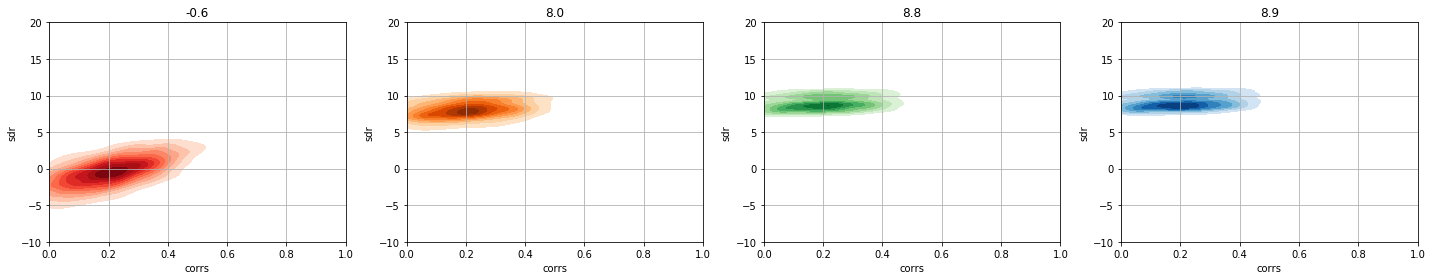

In [11]:
cmaps = ["Reds", "Oranges", "Greens", "Blues"] 
noises = [0.0, .5, 1.0, 1.5]
f, ax = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
    
    xx = ax[i % 4]
    xx.set_ylim(-10, 20)
    xx.set_xlim(.0, 1.)
    
    a = data_raw_high[data_raw_high['noise_train'] == noises[i]]['sdr']
    b = data_raw_high[data_raw_high['noise_train'] == noises[i]]['corrs']    
    xx = sns.kdeplot(b, a, cmap=cmaps[i % 4], shade=True, shade_lowest=False, ax=xx)
    xx.grid()
    xx.set_title("{:.2}".format(np.median(a)))

plt.tight_layout()

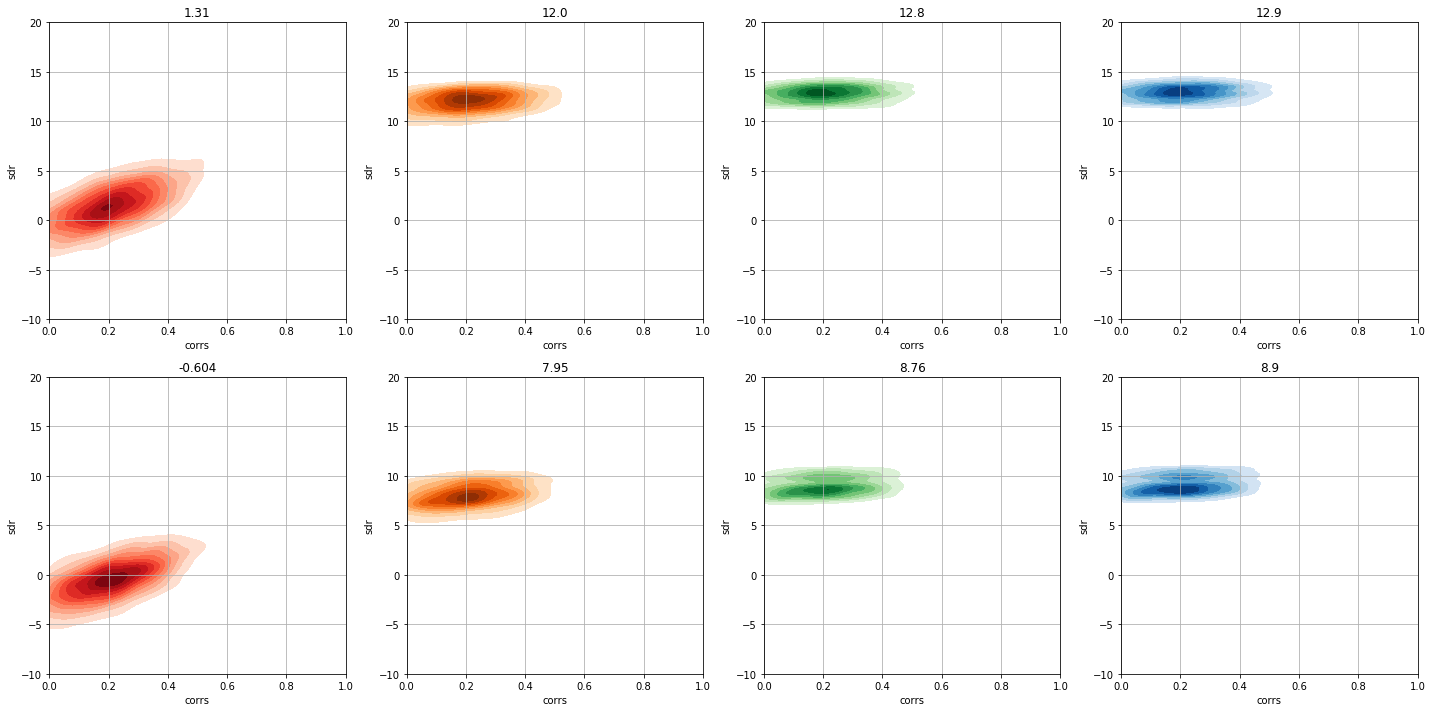

In [12]:
cmaps = ["Reds", "Oranges", "Greens", "Blues"] 
noises = [0.0, .5, 1.0, 1.5]
f, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(4):
    
    xx = ax[0][i % 4]
    xx.set_ylim(-10, 20)
    xx.set_xlim(.0, 1.)
    
    a = data_raw_low[data_raw_low['noise_train'] == noises[i]]['sdr']
    b = data_raw_low[data_raw_low['noise_train'] == noises[i]]['corrs']    
    xx = sns.kdeplot(b, a, cmap=cmaps[i % 4], shade=True, shade_lowest=False, ax=xx)
    xx.grid()
    xx.set_title("{:.3}".format(np.median(a)))

for i in range(4):
    
    xx = ax[1][i % 4]
    xx.set_ylim(-10, 20)
    xx.set_xlim(.0, 1.)
    
    a = data_raw_high[data_raw_high['noise_train'] == noises[i]]['sdr']
    b = data_raw_high[data_raw_high['noise_train'] == noises[i]]['corrs']    
    xx = sns.kdeplot(b, a, cmap=cmaps[i % 4], shade=True, shade_lowest=False, ax=xx)
    xx.grid()
    xx.set_title("{:.3}".format(np.median(a)))

plt.tight_layout()

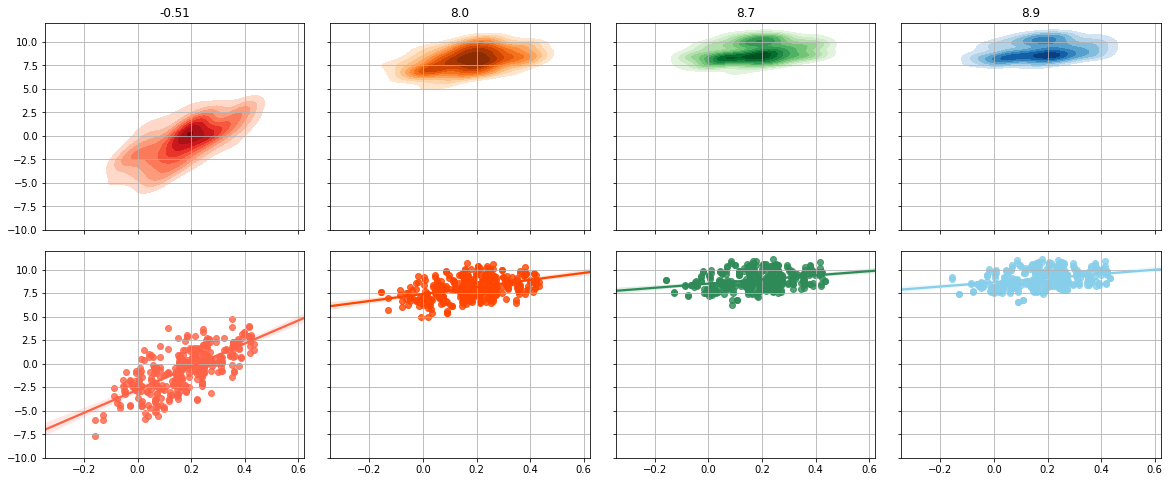

In [13]:
data = pd.read_csv('final_evaluation_eeg_with_corrs_v2.csv')
data_raw = data[data['dataset_name'] == 'recon test env']
data_raw = data_raw[data_raw["snr"] == 0]
data_raw = data_raw[data_raw["sub_id"] == 1]

cmaps = ["Reds", "Oranges", "Greens", "Blues"] 
noises = [0.0, .5, 1.0, 1.5]
f, ax = plt.subplots(2, 4, figsize=(20, 8), sharey='row', sharex='col')
for i in range(4):
    
    xx = ax[0][i % 4]
    xx.set_ylim(-10, 12)
#     xx.set_xlim(.0, 1.)
    
    a = data_raw[data_raw['noise_train'] == noises[i]]['sdr']
    b = data_raw[data_raw['noise_train'] == noises[i]]['corrs']
    xx = sns.kdeplot(b, a, cmap=cmaps[i % 4], shade=True, shade_lowest=False, ax=xx)
    xx.grid()
    xx.set_title("{:.2}".format(np.median(a)))
    xx.set_xlabel("")
    xx.set_ylabel("")


col = ['tomato', 'orangered', 'seagreen', 'skyblue', 'rebeccapurple', 'gray']
noises = [0.0, .5, 1.0, 1.5]

for i in range(4):
    
    xx = ax[1][i % 4]
    xx.set_ylim(-10, 12)
#     xx.set_xlim(.0, 1.)
    
    a = data_raw[data_raw['noise_train'] == noises[i]]['sdr']
    b = data_raw[data_raw['noise_train'] == noises[i]]['corrs'] 
    lr = LinearRegression().fit(np.array(a).reshape(-1, 1), np.array(b).reshape(-1, 1))
    cc = lr.coef_
    
    xx = sns.regplot(b, a, ax=xx, color=col[i % 4])
    xx.grid()
    xx.set_xlabel("")
    xx.set_ylabel("")
#     xx.set_title("{:.2}/{:.2}".format(1/cc[0][0], np.median(a)))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
# plt.tight_layout()
# plt.xlabel("Correlation")
# plt.ylabel("SDR (dB)")
# plt.savefig("eeg_speech_in_noise_sub0.pdf")

In [19]:
import statannot
from matplotlib import rc
plt.rcParams.update({'font.size': 24})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
rc('text', usetex=False)

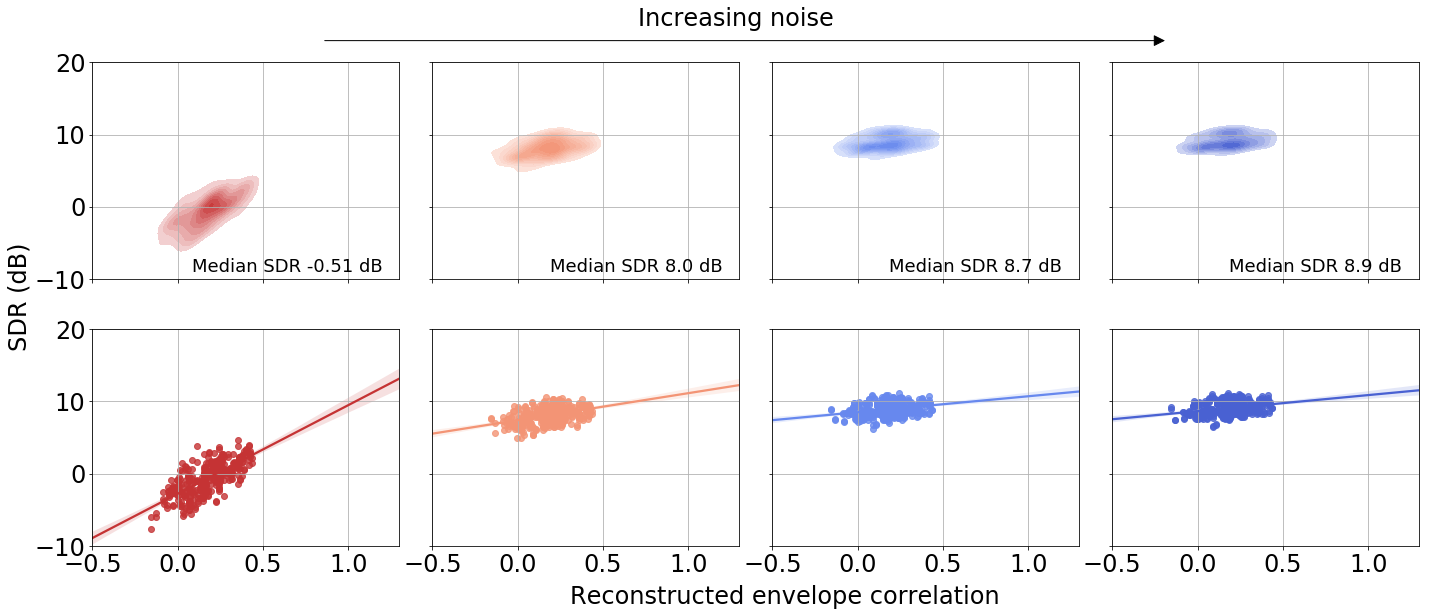

In [32]:
data = pd.read_csv('final_evaluation_eeg_with_corrs_v2.csv')
data_raw = data[data['dataset_name'] == 'recon test env']
data_raw = data_raw[data_raw["snr"] == 0]
data_raw = data_raw[data_raw["sub_id"] == 1]

pl = sns.color_palette("coolwarm_r", 20)
col = [pl[0], pl[4], pl[-3], pl[-1]]

noises = [0.0, .5, 1.0, 1.5]
f, ax = plt.subplots(2, 4, figsize=(20, 8), sharey='row', sharex='col')

for i in range(4):
    
    xx = ax[0][i % 4]
    xx.set_ylim(-10, 20)
    xx.set_xlim(-.5, 1.3)
    
    a = data_raw[data_raw['noise_train'] == noises[i]]['sdr']
    b = data_raw[data_raw['noise_train'] == noises[i]]['corrs']
    xx = sns.kdeplot(b, a, color=col[i], shade=True, shade_lowest=False, ax=xx)
    xx.grid()
    xx.set_xlabel("")
    xx.set_ylabel("")
    xx.text(1.2, -7., f"Median SDR {np.median(a):.2} dB", size=18, rotation=0.,
         ha="right", va="top",)


for i in range(4):
    
    xx = ax[1][i % 4]
    xx.set_ylim(-10, 20)
    xx.set_xlim(-.5, 1.3)
    
    a = data_raw[data_raw['noise_train'] == noises[i]]['sdr']
    b = data_raw[data_raw['noise_train'] == noises[i]]['corrs']   
    xx = sns.regplot(b, a, ax=xx, color=col[i % 6])
    xx.grid()
    xx.set_xlabel("")
    xx.set_ylabel("")
plt.subplots_adjust(hspace=0.1, wspace=0.1)
ax[0][0].text(-1.0, -7.5, f"SDR (dB)", size=24, rotation=90.,)
ax[1][0].text(2.3, -18, f"Reconstructed envelope correlation", size=24, rotation=0.,)

ax[0][0].text(2.7, 25, f"Increasing noise", size=24, rotation=0.,)

ax[0][0].annotate('', xy=(0.75, 1.1), xycoords='axes fraction', xytext=(3.5, 1.1), 
            arrowprops=dict(arrowstyle="<|-", color='k'))
plt.tight_layout()
plt.savefig("eeg_speech_vs_noise_v1.pdf", bbox_inches='tight', transparent=True)

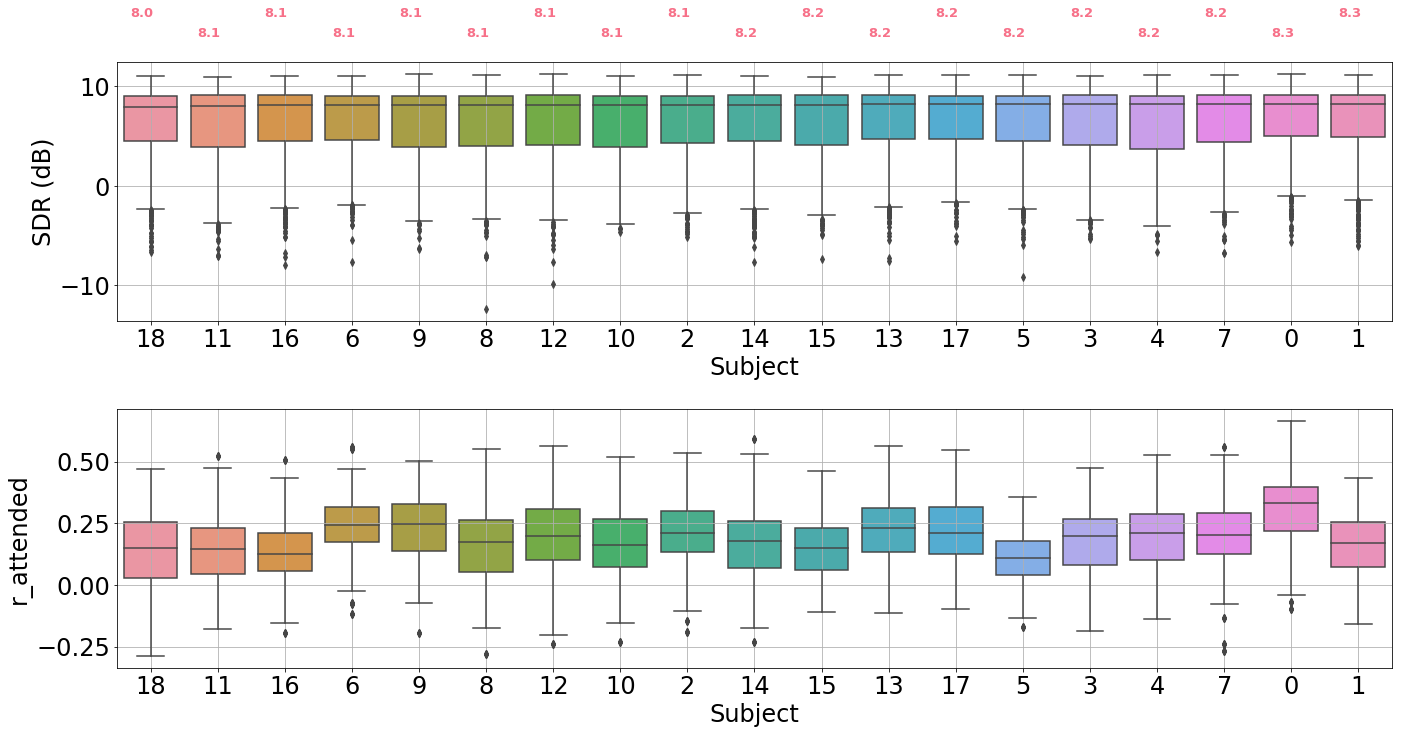

In [36]:
data = pd.read_csv('final_evaluation_eeg_with_corrs_v2.csv')
data_raw = data[data['dataset_name'] == 'recon test env']
data_raw = data_raw[data_raw["snr"] == 0]

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
data_x = data_raw[data_raw['sdr'] > -15]
data_x = data_x[data_x["causal"] == 0]
# data_x = data_x[data_x['noise_train'] == 2.0]
data_x["sub_id"] = np.int32(data_x['sub_id'])

my_order = list(data_x.groupby(by=["sub_id"])["sdr"].median().sort_values(ascending=True).index)


ll = sns.boxplot(data=data_x, x='sub_id', y='sdr', ax=ax[0], order=my_order)
_ = sns.boxplot(data=data_x, x='sub_id', y='corrs', ax=ax[1], order=my_order)

pl = sns.husl_palette(10)

# Select which box you want to change  
for l, k in enumerate(ll.artists):
    mmm = data_x[data_x["sub_id"] == my_order[l]]["sdr"].median()
    ax[0].text(l-0.3, 15 if l % 2 == 1 else 17, f"{mmm:.2}", color=pl[0], fontsize=13, weight='bold')
#     k.set_facecolor(pl[0])  # red - nh
    

# Change the appearance of that box

# mybox.set_edgecolor('black')
# mybox.set_linewidth(3)

# _ = sns.boxplot(data=data_x, x='sub_id', y='corrs', ax=ax[1]) 
# _ = sns.boxplot(data=data_x, x='hi', y='sdr', hue='sub_id', ax=ax[2])
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Subject")
ax[0].set_ylabel("SDR (dB)")
ax[1].set_ylabel("r_attended")
ax[1].set_xlabel("Subject")

plt.tight_layout()
plt.savefig('eeg_speech_vs_noise_all_sub_v1.pdf', transparent=True, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10, 5))
sdrs = np.array(list(data_x.groupby(by=["sub_id"])["sdr"].median()))
corrs = np.array(list(data_x.groupby(by=["sub_id"])["corrs"].median()))
plt.scatter(corrs, sdrs)
plt.grid()
plt.xlabel("Subject ID")
plt.ylabel("SDR (dB)")


# Speech vs Speech 

In [11]:
_model, _p = load_info_model('201908122515_ICM_noise_50_40_std_125_sep_NC')

NameError: name 'load_info_model' is not defined

In [12]:
data_dir = './eeg_2t/'
recon_dir = 'JH'
audio_dir = 'stimuli'

In [13]:
subs = [s for  s in os.listdir(os.path.join(data_dir, recon_dir)) if 'sub' in s]
n_subs = len(subs)
sub = 'sub-030'
data_sub = loadmat(os.path.join(data_dir, recon_dir, sub, 'recons'))
info_sub = loadmat(os.path.join(data_dir, recon_dir, sub, 'srdat'))

data_sub2 = loadmat(os.path.join(data_dir, recon_dir, sub, 'recons2'))
info_sub2 = loadmat(os.path.join(data_dir, recon_dir, sub, 'srdat2'))

data_sub3 = loadmat(os.path.join(data_dir, recon_dir, sub, 'recons3'))
info_sub3 = loadmat(os.path.join(data_dir, recon_dir, sub, 'audfeat2'))

print(data_sub.keys())
print(info_sub.keys())

dict_keys(['__header__', '__version__', '__globals__', 'recon', 'recon_stw'])
dict_keys(['__header__', '__version__', '__globals__', 'paud', 'peeg', 'id_st', 'id_tt', 'srdat'])


In [14]:
# info
valid_trials_id = np.where(info_sub['id_tt'])[0] + 1  # to map to audio

# recon env
recon_env = np.hstack(data_sub['recon'].squeeze()).T
n_trials = recon_env.shape[0]

# recon env with regul
recon_env_stw = np.hstack(data_sub['recon_stw'].squeeze()).T

# real env
target_env = info_sub['srdat'][0][0][0][0][0][1].squeeze().T
masker_env = info_sub['srdat'][0][0][0][0][0][2].squeeze().T


# info
valid_trials_id2 = np.where(info_sub2['id_tt'])[0] + 1  # to map to audio

# recon env
recon_env2 = np.hstack(data_sub2['recon'].squeeze()).T
n_trials2 = recon_env2.shape[0]

# recon env with regul
recon_env_stw2 = np.hstack(data_sub2['recon_stw'].squeeze()).T

# real env
target_env2 = info_sub2['srdat'][0][0][0][0][0][1].squeeze().T
masker_env2 = info_sub2['srdat'][0][0][0][0][0][2].squeeze().T


# info
valid_trials_id = np.where(info_sub['id_tt'])[0] + 1  # to map to audio

# recon env
recon_env3 = np.hstack(data_sub3['recon'].squeeze()).T
n_trials3 = recon_env3.shape[0]

# recon env with regul
recon_env_stw3 = np.hstack(data_sub3['recon_stw'].squeeze()).T

# real env
target_env3 = np.concatenate(info_sub3['audfeat2'][0][0][0].squeeze().T[valid_trials_id - 1], 1).T
masker_env3 = np.concatenate(info_sub3['audfeat2'][0][0][1].squeeze().T[valid_trials_id - 1], 1).T

print(target_env3.shape)

(32, 2369)


Text(0.5,1,'Masker')

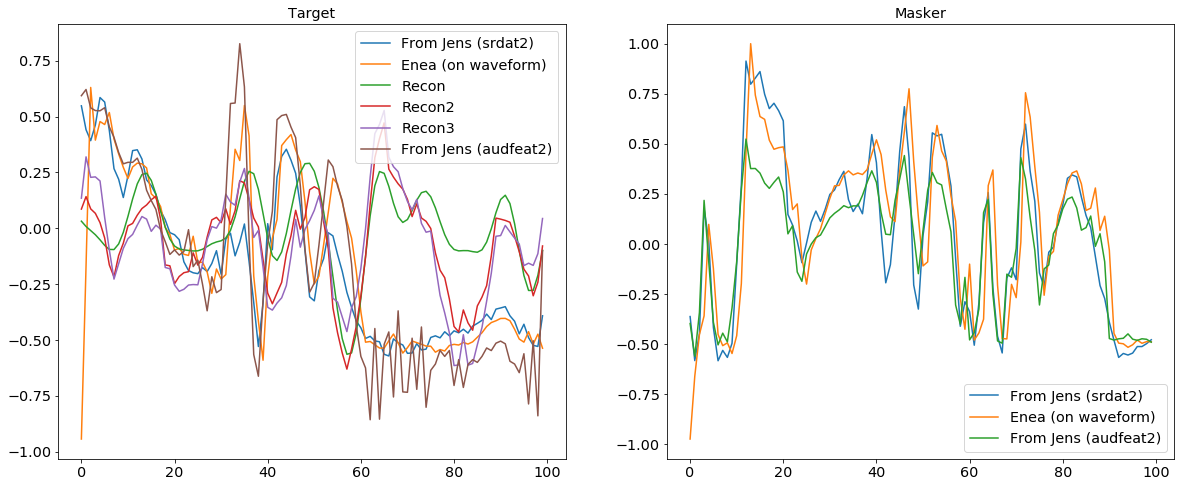

In [54]:
trial = 14

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fs, y_target = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                         f"t{valid_trials_id[trial]:0>3}.wav"))
fs, y_masker = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'masker', 
                                         f"m{valid_trials_id[trial]:0>3}.wav"))

y_target = y_target[:, 0].astype('float32')
y_masker = y_masker[:, 0].astype('float32')



y_target = resample2(y_target, 44100, 8000)
y_masker = resample2(y_masker, 44100, 8000)
fs = 8000

# mix high/low snr
y1 = y_target[6 * fs:43 * fs] 
y2 = y_masker[6 * fs:43 * fs]

y1 = y1
y2 = y2

y1 = true_SNR(y1, snr_range=(0, 0))
y2 = true_SNR(y2, snr_range=(0, 0)) 

mix = norm_power_wav(y1 + y2)
s1 = y1
s2 = y2

_true_env = envelope(s1)
_wrong_env = envelope(s2)

_target_env = target_env[trial]
_masker_env = masker_env[trial]
_recon_env = recon_env[trial]
_recon_env2 = recon_env2[trial]
_recon_env3 = recon_env3[trial]

_target_env2 = target_env2[trial]
_masker_env2 = masker_env2[trial]

_target_env3 = target_env3[trial]
_masker_env3 = masker_env3[trial]


fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ax[0].plot(norm_power_wav(_target_env)[:100], label='From Jens (srdat)')
ax[0].plot(norm_power_wav(_target_env2)[:100], label='From Jens (srdat2)')
ax[0].plot(norm_power_wav(_true_env)[:100], label='Enea (on waveform)')
# ax[0].plot(norm_power_wav(_recon_env)[:100], label='Recon')
# ax[0].plot(norm_power_wav(_recon_env2)[:100], label='Recon2')
# ax[0].plot(norm_power_wav(_recon_env3)[:100], label='Recon3')
ax[0].plot(norm_power_wav(_target_env3)[:100], label='From Jens (audfeat2)')



# ax[1].plot(norm_power_wav(_masker_env)[:100], label='From Jens (srdat)')
ax[1].plot(norm_power_wav(_masker_env2)[:100], label='From Jens (srdat2)')
ax[1].plot(norm_power_wav(_wrong_env)[:100], label='Enea (on waveform)')
ax[1].plot(norm_power_wav(_masker_env3)[:100], label='From Jens (audfeat2)')

ax[0].legend()
ax[1].legend()
ax[0].set_title('Target')
ax[1].set_title('Masker')

# plt.savefig('ex_envs_srdat.pdf')

(2369,)
(32, 2369)
[ 2  3  4  6  8  9 11 12 13 15 19 20 21 24 25 26 27 28 30 31]


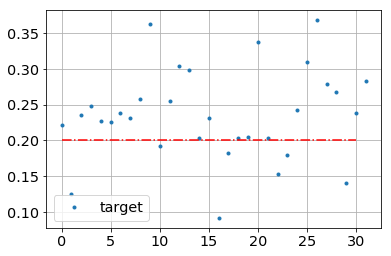

In [107]:
# plt.plot(target_env[10][:100] / np.max(np.abs(target_env[10])))
# plt.plot(recon_env_stw[10][:100] / np.max(np.abs(recon_env[10])))
print(target_env3[0].shape)
print(recon_env3.shape)
A = np.array([np.corrcoef(a, b)[0, 1] for a, b in zip(target_env3, recon_env3)])
B = np.array([np.corrcoef(a, b)[0, 1] for a, b in zip(masker_env3, recon_env3)])
valid_trials = np.where(A - B > 0.2)[0]
print(valid_trials)
plt.plot(A, '.', label='target')
plt.plot([0, 30], [0.2, 0.2], 'r-.')
# plt.plot(B, '.', label='masker')
plt.legend()
# plt.plot(A - B, '.')
plt.grid()

In [61]:
models = [
    '201908072914_ICM_noise_30_24_std_125_sep_NC',]
#           '201908121409_ICM_baseline_00_1_dan_125_sep_NC',
#           '201908154345_ICM_noise_10_8_dan_125_sep_NC',
#           '201908082058_ICM_noise_20_16_dan_125_sep_NC',
#           '201908005636_ICM_noise_30_24_dan_125_sep_NC',]
#         '201909012123_ICM_noise_60_24_dan_125_sep_NC',]
#         '201909184527_ICM_noise_40_24_dan_125_sep_NC',]
#         '201909022302_ICM_noise_45_24_dan_125_sep_NC',]
#           '201909145306_ICM_noise_45_36_dan_125_sep_NC',]
#           '201909111230_ICM_noise_50_40_dan_125_sep_NC']
noises = [0, ]
          #10, 20, 30,40, 50]

In [114]:
n_samples = 4
batch_size = 1
max_len = 64000
ml_e = max_len // 125

# _model, _p = load_info_model('201909155415_ICM_baseline_NOISEONLY_20_1_dan_125_sep_NC')
# _model, _p = load_info_model('201909140522_ICM_baseline_NOISEONLY_r2_20_1_dan_125_sep_NC')
_model, _p = load_info_model('201908122515_ICM_noise_50_40_std_125_sep_NC')


all_trials_sdr = []
all_trials_ori_sdr = []
all_trials_corrs =  []
all_trials_wrong_corrs = []
trial = 22
j = 0

if os.path.isfile(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                                     f"t{valid_trials_id[trial]:0>3}woa.wav")):
    fs, y_target = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                         f"t{valid_trials_id[trial]:0>3}woa.wav"))
    fs, y_masker = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'masker', 
                                             f"m{valid_trials_id[trial]:0>3}woa.wav"))
    print("Hearing Impaired")
else:
    print("Normal Hearing")
    fs, y_target = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                         f"t{valid_trials_id[trial]:0>3}.wav"))
    fs, y_masker = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'masker', 
                                             f"m{valid_trials_id[trial]:0>3}.wav"))

y_target = y_target[:, 0].astype('float32')
y_masker = y_masker[:, 0].astype('float32')

y_target = unit_power(y_target)
y_masker = unit_power(y_masker)

y_target = resample2(y_target, 44100, 8000)
y_masker = resample2(y_masker, 44100, 8000)
fs = 8000
# y_target, fs = librosa.load(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
#                                          f"t{valid_trials_id[trial]:0>3}.wav"), sr=8000)
# y_masker, fs = librosa.load(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'masker', 
#                                          f"m{valid_trials_id[trial]:0>3}.wav"), sr=8000)

# mix high/low snr
y1 = y_target[6 * fs:43 * fs] 
y2 = y_masker[6 * fs:43 * fs]

y1 = y1[:n_samples * max_len].reshape(-1, max_len)
y2 = y2[:n_samples * max_len].reshape(-1, max_len)

y1 = np.array([true_SNR(_y, snr_range=(0, 0)) for _y in y1])
y2 = np.array([true_SNR(_y, snr_range=(0, 0)) for _y in y2])

mix = norm_power_wav(y1 + y2)
s1 = y1
s2 = y2

_target_env = target_env3[trial][:n_samples * ml_e].reshape(-1, ml_e)
_masker_env = masker_env3[trial][:n_samples * ml_e].reshape(-1, ml_e)
_recon_env = recon_env3[trial][:n_samples * ml_e].reshape(-1, ml_e)

env_r = np.array([norm_power_wav(np.hstack([_r, np.zeros((1, ))])) for _r in _recon_env])
env_t = np.array([norm_power_wav(np.hstack([_t, np.zeros((1, ))])) for _t in _target_env])

mix = torch.from_numpy(mix.astype('float32'))
env_r = torch.from_numpy(env_r.astype('float32'))
env_t = torch.from_numpy(env_t.astype('float32'))
s1 = torch.from_numpy(s1.astype('float32'))

Normal Hearing


In [115]:
j = 0
recon_ = _model([mix[j].unsqueeze(0), env_r[j].unsqueeze(0)])
recon_true = _model([mix[j].unsqueeze(0), env_t[j].unsqueeze(0)])

In [116]:
print(sep_eval.sdr(recon_.squeeze().data.numpy(), s1.squeeze().data.numpy()[j], average=True))
print(sep_eval.sdr(recon_true.squeeze().data.numpy(), s1.squeeze().data.numpy()[j], average=True))

print(np.corrcoef(_target_env[j], _recon_env[j])[0, 1])
print(np.corrcoef(_masker_env[j], _recon_env[j])[0, 1])

ipd.display(ipd.Audio(recon_.data.numpy()[0],rate=8000))
ipd.display(ipd.Audio(recon_true.data.numpy()[0],rate=8000))
ipd.display(ipd.Audio(y1[0],rate=8000))

5.148264
7.84177
0.22193320454295956
0.08177270951642747


In [14]:
ipd.display(ipd.Audio(mix[0],rate=8000))

In [ ]:
_noise = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
_corrs = []
_sdr = []
_nnoise = []
for s in _noise:
    
    print(s)
    _env_t = env_t + np.random.randn(*env_t.shape) * s
    _env_t = torch.from_numpy(_env_t.astype('float32'))
    
    for j in range(4):
        recon_true = _model([mix[j].unsqueeze(0), _env_t[j].unsqueeze(0)])
        _sdr.append(sep_eval.sdr(recon_true.squeeze().data.numpy(), s1.squeeze().data.numpy()[j], average=True))
        _corrs.append(np.corrcoef(_target_env[j], _env_t[j].squeeze().data.numpy()[:-1])[0, 1])
        _nnoise.append(s)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(_nnoise, _corrs, '.')
ax[1].plot(_corrs, _sdr, '.')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(_nnoise, _corrs, '.')
ax[1].plot(_corrs, _sdr, '.')

In [ ]:
# plt.plot(norm_power_wav(_true_env))
plt.plot(norm_power_wav(_target_env))
# plt.plot(norm_power_wav(_recon_env_stw))
plt.plot(norm_power_wav(_recon_env))
# print(np.corrcoef(_target_env, _recon_env_stw)[0, 1])
print(np.corrcoef(_target_env, _recon_env)[0, 1])

In [ ]:
def corr_env(y):
    raw_gt = y
    raw_gt /= np.sqrt(np.mean((raw_gt - np.mean(raw_gt)) ** 2)) + 1e-15
    raw_gt *= 0.025
    raw_gt = daniel_env(raw_gt)
    return raw_gt

In [101]:
import time
n_samples = 4
batch_size = 1
max_len = 64000
ml_e = int(max_len / 125)

all_res = {}
models= ['201909140522_ICM_baseline_NOISEONLY_r2_20_1_dan_125_sep_NC']
noises = [0]

for model_name, noise in zip(models, noises):
    print(f"Doing model {model_name}")
    _model, _p = load_info_model(model_name)

    all_trials_sdr = []
    all_trials_ori_sdr = []
    all_trials_corrs =  []
    all_trials_wrong_corrs = []
    all_recon = []

    for trial in range(32):
        print(f"\t trial: {trial}")
        # audio
        if os.path.isfile(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                                     f"t{valid_trials_id[trial]:0>3}woa.wav")):
            fs, y_target = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                                 f"t{valid_trials_id[trial]:0>3}woa.wav"))
            fs, y_masker = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'masker', 
                                                     f"m{valid_trials_id[trial]:0>3}woa.wav"))
            print("Hearing Impaired")
        else:
            print("Normal Hearing")
            fs, y_target = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                                 f"t{valid_trials_id[trial]:0>3}.wav"))
            fs, y_masker = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'masker', 
                                                     f"m{valid_trials_id[trial]:0>3}.wav"))

        y_target = y_target[:, 0].astype('float32')
        y_masker = y_masker[:, 0].astype('float32')
        
        y_target = resample2(y_target, 44100, 8000)
        y_masker = resample2(y_masker, 44100, 8000)
        fs = 8000


        # y_target = norm_power_wav(y_target)
        # y_masker = norm_power_wav(y_masker)
    
        # mix high/low snr
        y1 = y_target[6 * fs:43 * fs] 
        y2 = y_masker[6 * fs:43 * fs]
        
        y1 = y1[:n_samples * max_len].reshape(-1, max_len)
        y2 = y2[:n_samples * max_len].reshape(-1, max_len)

        y1 = np.array([true_SNR(_y, snr_range=(0, 0)) for _y in y1])
        y2 = np.array([true_SNR(_y, snr_range=(0, 0)) for _y in y2])
        
        mix = np.array([norm_power_wav(_y1 + _y2) for _y1, _y2 in zip(y1, y2)])
        s1 = y1

        _recon_env = recon_env[trial][:n_samples * ml_e].reshape(-1, ml_e)
        _true_env = target_env[trial][:n_samples * ml_e].reshape(-1, ml_e)
        _wrong_env = masker_env[trial][:n_samples * ml_e].reshape(-1, ml_e)
        
        env_t = np.array([norm_power_wav(a) for a in np.hstack([_true_env, np.zeros((n_samples, 1))])])
        env_r = np.array([norm_power_wav(a) for a in np.hstack([_recon_env, np.zeros((n_samples, 1))])])

        mix = torch.from_numpy(mix.astype('float32'))
        env_t = torch.from_numpy(env_t.astype('float32'))
        env_r = torch.from_numpy(env_r.astype('float32'))
        s1 = torch.from_numpy(s1.astype('float32'))
        for i in range(n_samples // batch_size):
            print(f"\t\t batch: {i + 1}/{n_samples // batch_size}")
            slc = slice(i * batch_size, (i + 1) * batch_size)
            recon_true = _model([mix[slc], env_t[slc]])
            recon_recon = _model([mix[slc], env_r[slc]])
            b = [sep_eval.sdr(recon_true.squeeze().data.numpy(), s1[slc].squeeze().data.numpy(), average=False)]
            a = [sep_eval.sdr(recon_recon.squeeze().data.numpy(), s1[slc].squeeze().data.numpy(), average=False)]
            all_trials_sdr.extend(a)
            all_trials_ori_sdr.extend(b)
            all_recon.extend([recon_recon.squeeze().data.numpy()])
            
            c = [np.corrcoef(_a, _b)[1, 0] for _a, _b in zip(_true_env[slc], _recon_env[slc])]
            d = [np.corrcoef(_a, _b)[1, 0] for _a, _b in zip(_true_env[slc], _wrong_env[slc])]
            all_trials_corrs.extend(c)
            all_trials_wrong_corrs.extend(d)
            print(f"Real is {np.mean(b):.2f} || BISS is {np.mean(a):.2f} == {np.mean(c):.2f} ({np.mean(d):.2f})")
    
    all_res[noise] = {'sdr': all_trials_sdr, 
                      'ori_sdr': all_trials_ori_sdr,
                     'corr': all_trials_corrs,
                     'w_corr': all_trials_wrong_corrs}

Doing model 201909140522_ICM_baseline_NOISEONLY_r2_20_1_dan_125_sep_NC
	 trial: 0
Normal Hearing
		 batch: 1/4
Real is 8.37 || BISS is -6.20 == 0.38 (0.02)
		 batch: 2/4
Real is 6.98 || BISS is -8.33 == 0.31 (-0.07)
		 batch: 3/4
Real is -4.74 || BISS is -7.36 == 0.35 (-0.02)
		 batch: 4/4
Real is 5.37 || BISS is -14.97 == 0.18 (-0.15)
	 trial: 1
Normal Hearing


KeyboardInterrupt: 

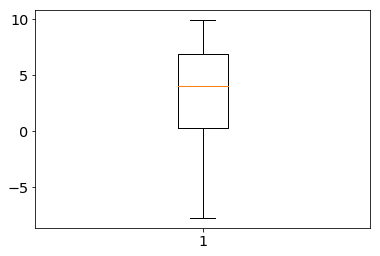

In [98]:
_ = plt.boxplot(all_trials_sdr)

4.03633

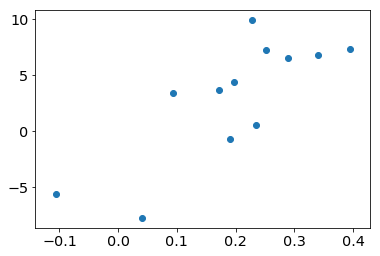

In [99]:
plt.scatter(np.array(all_trials_corrs)[0:] - np.array(all_trials_wrong_corrs)[0:], all_trials_sdr[0:])
np.median(all_trials_sdr)
# plt.legend()

In [ ]:
plt.scatter(np.array(all_trials_corrs)[0:] - np.array(all_trials_wrong_corrs)[0:], all_trials_sdr[0:], c=np.concatenate([np.ones((4,)) * i for i in range(11)]))
np.median(all_trials_sdr)
# plt.legend()

In [ ]:
plt.plot(_true_env[2] / np.max(np.abs(_true_env[2])))
plt.plot(_wrong_env[2] / np.max(np.abs(_wrong_env[2])))
plt.plot(_recon_env[2] / np.max(np.abs(_recon_env[2])))

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(15, 3))

noises = [0, 10, 20, 30, 40, 50]
trial = 10
for noise, aax in zip(noises, ax):
    r = all_res[noise]
    
    aax.scatter(np.array(r['corr'][trial * 4:(trial + 1)  * 4]), r['sdr'][trial * 4:(trial + 1)  * 4], 
#             c=np.concatenate([np.ones((4)) * i for i in range(32)]))
                c=range(4))
    aax.set_ylim([-10,15])
    aax.set_title(f"{noise}: {np.median(r['sdr'][trial * 4:(trial + 1)  * 4]):.1f}")

In [ ]:
r = all_res[30]

a = []
b = []
c = []
d = []

for t in range(32):


    a.append(np.mean(r['corr'][t * 4:(t + 1)  * 4]))
    b.append(np.mean(r['w_corr'][t * 4:(t + 1)  * 4]))
    c.append(np.mean(r['sdr'][t * 4:(t + 1)  * 4]))
    d.append(np.mean(r['ori_sdr'][t * 4:(t + 1)  * 4]))

# plt.plot(np.array(a) - np.array(b), c, '.', np.array(a) - np.array(b), d, 'x')
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(c, '.')
ax[1].plot(a, '.')

In [ ]:
plt.figure(figsize=(20,10))
slc = slice(500, 600)
plt.plot(norm_power_wav(recon_env[5][slc]), label='recon')
plt.plot(norm_power_wav(recon_env_stw[5][slc]), label='recon-s')
plt.plot(norm_power_wav(target_env[5][slc]), label='target')
# plt.plot(norm_power_wav(masker_env[5][slc]), label='masker')
plt.legend()

In [ ]:
print(ml_e)

## prepare dataset for eval

In [ ]:
from tqdm import tqdm
n_samples = 4
batch_size = 1
max_len = 64000
ml_e = int(max_len / 125)

mix = []
s1 = []
env = []
env_t = []
env_stw = []
corrs = []
corrs_stw = []
corrs_wrong = []
sub_id = []
trial_id = []
hi = []

for sub in sorted(subs):
    print(f"Doing sub {sub}")
    data_sub = loadmat(os.path.join(data_dir, recon_dir, sub, 'recons3'))
    info_sub = loadmat(os.path.join(data_dir, recon_dir, sub, 'srdat2'))
    extra_info = loadmat(os.path.join(data_dir, recon_dir, sub, 'audfeat2'))
    
    # info
    valid_trials_id = np.where(info_sub['id_tt'])[0] + 1  # to map to audio

    # recon env
    recon_env = np.hstack(data_sub['recon'].squeeze()).T
    n_trials = recon_env.shape[0]

    # recon env with regul
    recon_env_stw = np.hstack(data_sub['recon_stw'].squeeze()).T
    n_trials = recon_env_stw.shape[0]

    # real env
    target_env = np.concatenate(extra_info['audfeat2'][0][0][0].squeeze().T[valid_trials_id - 1], 1).T
    masker_env = np.concatenate(extra_info['audfeat2'][0][0][1].squeeze().T[valid_trials_id - 1], 1).T
    
    for trial in tqdm(range(32)):
        if os.path.isfile(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                                     f"t{valid_trials_id[trial]:0>3}woa.wav")):
            _hi = 1
            fs, y_target = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                                 f"t{valid_trials_id[trial]:0>3}woa.wav"))
            fs, y_masker = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'masker', 
                                                     f"m{valid_trials_id[trial]:0>3}woa.wav"))

            y_target = y_target[:, 0].astype('float32')
            y_masker = y_masker[:, 0].astype('float32')

            y_target = resample2(y_target, 44100, 8000)
            y_masker = resample2(y_masker, 44100, 8000)
            fs = 8000
        else:
            _hi = 0
            fs, y_target = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'target', 
                                                 f"t{valid_trials_id[trial]:0>3}.wav"))
            fs, y_masker = wavfile.read(os.path.join(data_dir, audio_dir, sub.replace('-', ''), 'masker', 
                                                     f"m{valid_trials_id[trial]:0>3}.wav"))

            y_target = y_target[:, 0].astype('float32')
            y_masker = y_masker[:, 0].astype('float32')

            y_target = resample2(y_target, 44100, 8000)
            y_masker = resample2(y_masker, 44100, 8000)
            fs = 8000

        # mix high/low snr
        y1 = y_target[6 * fs:43 * fs] 
        y2 = y_masker[6 * fs:43 * fs]
        
        y1 = y1[:n_samples * max_len].reshape(-1, max_len)
        y2 = y2[:n_samples * max_len].reshape(-1, max_len)

        y1 = np.array([true_SNR(_y, snr_range=(0, 0)) for _y in y1])
        y2 = np.array([true_SNR(_y, snr_range=(0, 0)) for _y in y2])
        
        _mix = np.array([norm_power_wav(_y1 + _y2) for _y1, _y2 in zip(y1, y2)])
        _s1 = y1

        _recon_env = recon_env[trial][:n_samples * ml_e].reshape(-1, ml_e)
        _recon_envs = recon_env_stw[trial][:n_samples * ml_e].reshape(-1, ml_e)
        _true_env = target_env[trial][:n_samples * ml_e].reshape(-1, ml_e)
        _wrong_env = masker_env[trial][:n_samples * ml_e].reshape(-1, ml_e)
        _env_t = np.array([norm_power_wav(a) for a in np.hstack([_true_env, np.zeros((n_samples, 1))])])
        _env_r = np.array([norm_power_wav(a) for a in np.hstack([_recon_env, np.zeros((n_samples, 1))])])
        _env_s = np.array([norm_power_wav(a) for a in np.hstack([_recon_envs, np.zeros((n_samples, 1))])])
        
        sub_id.extend([int(sub[4:])] * n_samples)
        trial_id.extend([trial] * n_samples)
        hi.extend([_hi] * n_samples)
        s1.append(_s1)
        mix.append(_mix)
        env.append(_env_r)
        env_stw.append(_env_s)
        env_t.append(_env_t)
        corrs_wrong.extend([np.corrcoef(_a, _b)[1, 0] for _a, _b in zip(_wrong_env, _true_env)])
        corrs.extend([np.corrcoef(_a, _b)[1, 0] for _a, _b in zip(_recon_env, _true_env)])
        corrs_stw.extend([np.corrcoef(_a, _b)[1, 0] for _a, _b in zip(_recon_envs, _true_env)])

Doing sub sub-001


100%|██████████| 32/32 [01:50<00:00,  3.39s/it]


Doing sub sub-002


100%|██████████| 32/32 [01:51<00:00,  3.35s/it]


Doing sub sub-003


100%|██████████| 32/32 [01:52<00:00,  3.52s/it]


Doing sub sub-004


100%|██████████| 32/32 [01:52<00:00,  3.34s/it]


Doing sub sub-005


100%|██████████| 32/32 [01:52<00:00,  3.56s/it]


Doing sub sub-006


100%|██████████| 32/32 [01:50<00:00,  3.39s/it]


Doing sub sub-007


100%|██████████| 32/32 [01:51<00:00,  3.50s/it]


Doing sub sub-008


100%|██████████| 32/32 [01:56<00:00,  3.73s/it]


Doing sub sub-009


100%|██████████| 32/32 [01:53<00:00,  3.50s/it]


Doing sub sub-010


100%|██████████| 32/32 [01:52<00:00,  3.38s/it]


Doing sub sub-011


100%|██████████| 32/32 [01:56<00:00,  3.73s/it]


Doing sub sub-012


100%|██████████| 32/32 [01:50<00:00,  3.52s/it]


Doing sub sub-013


100%|██████████| 32/32 [01:53<00:00,  3.63s/it]


Doing sub sub-014


100%|██████████| 32/32 [01:56<00:00,  3.57s/it]


Doing sub sub-015


100%|██████████| 32/32 [01:51<00:00,  3.60s/it]


Doing sub sub-016


100%|██████████| 32/32 [01:53<00:00,  3.47s/it]


Doing sub sub-017


100%|██████████| 32/32 [01:57<00:00,  3.77s/it]


Doing sub sub-018


100%|██████████| 32/32 [01:54<00:00,  3.84s/it]


Doing sub sub-019


100%|██████████| 32/32 [01:50<00:00,  3.56s/it]


Doing sub sub-020


100%|██████████| 32/32 [01:57<00:00,  3.78s/it]


Doing sub sub-021


 59%|█████▉    | 19/32 [01:10<00:46,  3.60s/it]

# map for good trials

In [15]:
over_corr = {}
over_corr_stw = {}

for sub in sorted(subs):
    print(f"Doing sub {sub}")
#     data_sub = loadmat(os.path.join(data_dir, recon_dir, sub, 'recons3'))
    info_sub = loadmat(os.path.join(data_dir, recon_dir, sub, 'srdat2'))
    
    # info
    data_sub = loadmat(os.path.join(data_dir, recon_dir, sub, 'recons3'))
    extra_info = loadmat(os.path.join(data_dir, recon_dir, sub, 'audfeat2'))
    valid_trials_id = np.where(info_sub['id_tt'])[0] + 1  # to map to audio

    # recon env
    recon_env = np.hstack(data_sub['recon'].squeeze()).T
    n_trials = recon_env.shape[0]

    # recon env with regul
    recon_env_stw = np.hstack(data_sub['recon_stw'].squeeze()).T
    n_trials = recon_env_stw.shape[0]

    # real env
    target_env = np.concatenate(extra_info['audfeat2'][0][0][0].squeeze().T[valid_trials_id - 1], 1).T
    masker_env = np.concatenate(extra_info['audfeat2'][0][0][1].squeeze().T[valid_trials_id - 1], 1).T
#     target_env = info_sub['srdat'][0][0][0][0][0][1].squeeze().T
#     masker_env = info_sub['srdat'][0][0][0][0][0][2].squeeze().T
    
    A = np.array([np.corrcoef(a, b)[0, 1] for a, b in zip(target_env, recon_env)])
    B = np.array([np.corrcoef(a, b)[0, 1] for a, b in zip(masker_env, recon_env)])
    valid_trials = np.where(A - B > 0.3)[0]
    
    over_corr[int(sub[4:])] = valid_trials
    
    A = np.array([np.corrcoef(a, b)[0, 1] for a, b in zip(target_env, recon_env_stw)])
    B = np.array([np.corrcoef(a, b)[0, 1] for a, b in zip(masker_env, recon_env_stw)])
    valid_trials = np.where(A - B > 0.3)[0]
    
    over_corr_stw[int(sub[4:])] = valid_trials
    
    
    

Doing sub sub-001
Doing sub sub-002
Doing sub sub-003
Doing sub sub-004
Doing sub sub-005
Doing sub sub-006
Doing sub sub-007
Doing sub sub-008
Doing sub sub-009
Doing sub sub-010
Doing sub sub-011
Doing sub sub-012
Doing sub sub-013
Doing sub sub-014
Doing sub sub-015
Doing sub sub-016
Doing sub sub-017
Doing sub sub-018
Doing sub sub-019
Doing sub sub-020
Doing sub sub-021
Doing sub sub-022
Doing sub sub-023
Doing sub sub-024
Doing sub sub-025
Doing sub sub-026
Doing sub sub-027
Doing sub sub-028
Doing sub sub-029
Doing sub sub-030
Doing sub sub-031
Doing sub sub-032
Doing sub sub-033
Doing sub sub-034
Doing sub sub-035
Doing sub sub-036
Doing sub sub-037
Doing sub sub-038
Doing sub sub-039
Doing sub sub-040
Doing sub sub-041
Doing sub sub-042
Doing sub sub-043
Doing sub sub-044


In [16]:
s1 = np.vstack(s1)
mix = np.vstack(mix)
env = np.vstack(env)

env_t = np.vstack(env_t)

env_stw = np.vstack(env_stw)

corrs = np.array(corrs)
corrs_wrong = np.array(corrs_wrong)
corrs_stw = np.array(corrs_stw)

trial_id = np.array(trial_id)
sub_id = np.array(sub_id)
hi = np.array(hi)

NameError: name 's1' is not defined

In [119]:
print("REAL test MIX: {}".format(mix.shape))
print("REAL test ENV: {}".format(env.shape))
print("REAL test s1: {}".format(s1.shape))
print("REAL test ENV STW: {}".format(env_stw.shape))
print("REAL test ENV T: {}".format(env_t.shape))
print("REAL test corrs: {}".format(corrs.shape))
print("REAL test corrs_stw: {}".format(np.array(corrs_stw).shape))
print("REAL test corrs wrong: {}".format(corrs_wrong.shape))
print("REAL test trial: {}".format(np.array(trial_id).shape))
print("REAL test sub: {}".format(np.array(sub_id).shape))
print("REAL test hi: {}".format(np.array(hi).shape))

REAL test MIX: (5632, 64000)
REAL test ENV: (5632, 513)
REAL test s1: (5632, 64000)
REAL test ENV STW: (5632, 513)
REAL test ENV T: (5632, 513)
REAL test corrs: (5632,)
REAL test corrs_stw: (5632,)
REAL test corrs wrong: (5632,)
REAL test trial: (5632,)
REAL test sub: (5632,)
REAL test hi: (5632,)


In [123]:
import pickle as pkl
pkl.dump({'s1': s1, 'env': env, 'env_t': env_t, 
          #'env_stw': env_stw, 
          'corrs_w': corrs_wrong, 'trial_id': trial_id,
          'corrs': corrs, 'mix': mix, 'sub_id': sub_id, 'hi': hi,
         #'corrs_stw': corrs_stw
         }, open('prepared_speech_vs_speech_eeg_v5.pkl', 'wb'))



# Plot results

In [29]:
import statannot
from matplotlib import rc
plt.rcParams.update({'font.size': 22})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
rc('text', usetex=False)

In [18]:
data = pd.read_csv('final_evaluation_eeg_sp_vs_sp_with_corrs_v7.csv')
print(list(set(data["dataset_name"])))
data_raw = data[data['dataset_name'] == 'recon test env']
data_raw = data_raw[data_raw["sub_id"] != 32]
print(len(data_raw))
# data_raw = data_raw[data_raw["model"] == '201909140522_ICM_baseline_NOISEONLY_r2_20_1_dan_125_sep_NC']  # 5.8 / 4.1
# data_raw = data_raw[data_raw["model"] == '201909140522_ICM_baseline_NOISEONLY_r2_20_1_std_125_sep_NC']  # 5.7 / 1.9
# data_raw = data_raw[data_raw["model"] == '201909150719_ICM_baseline_NOISEONLY_r2_20_1_dan_125_sep_NC']  # 5.7 / 2.1
# data_raw = data_raw[data_raw["model"] == '201909142843_ICM_noise_NOISEONLY_r2_10_1_dan_125_sep_NC']  # 6 / -0.42
# data_raw = data_raw[data_raw["model"] == '201909144604_ICM_noise_NOISEONLY_r3_20_1_dan_125_sep_NC']  # 5.4 / -2.4


['recon test env']
66048


In [19]:
assert list(set(data_raw["trial_id"])) == list(range(32))
assert list(set(data_raw["sub_id"])) == list(range(1, 45))
print("All good")

AssertionError: 

In [20]:
def remove_worst(x, n=10):
    x = np.array(x)
    idx = np.argsort(x)[n:]
    return x[idx], idx

In [21]:
xs = []
ys = []
zs = []
for i in range(1, 45):
    data_x = data_raw[data_raw["sub_id"] == i]
    data_x = data_x[data_x["causal"] == 0]
#     xs.append("Normal Hearing" if list(data_x["hi"])[0] == 0.0 else "Hearing Impaired")
    xs.append(list(data_x["hi"])[0])
    ys.append(data_x['corrs'])
    _z, _ = remove_worst(data_x[data_x['noise_train'] == 2.0]['sdr'], 0)
    zs.append(_z)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].boxplot(ys, range(44))
ax[0].scatter(range(44), [np.mean(s) for s in ys], c=np.array(xs))
ax[1].boxplot(zs, range(44))
# _ = ax.set_xticks(range(44))
# _ = ax.set_xticklabels(xs, rotation=45)
ax[0].grid()
ax[1].grid()

IndexError: list index out of range

In [22]:
f = data_x[data_x["sub_id"] == my_order[l]]["sdr"].median()
print(type(f))


NameError: name 'my_order' is not defined

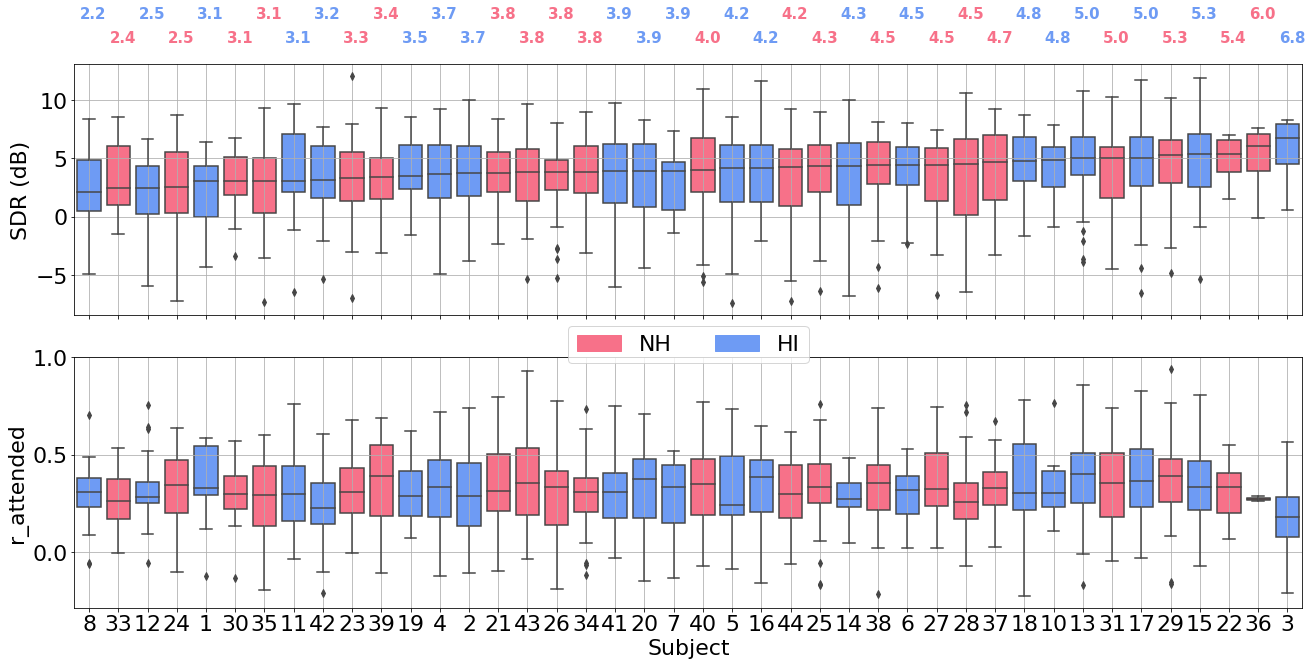

In [43]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
data_x = data_raw[data_raw['sdr'] > -7.5]
data_x = data_x[data_x["causal"] == 0]
data_x = data_x[data_x['noise_train'] == 5.0]
data_x["sub_id"] = np.int32(data_x['sub_id'])
data_x["real_corr"] = data_x["corrs"] - data_x["corrs_w"]
ll = []
for d in data_x.iterrows():
    ll.append(1 if d[1].trial_id in over_corr[d[1].sub_id] else 0)

data_x["valid"] = ll
data_x = data_x[data_x["valid"] == 1]

my_order = list(data_x.groupby(by=["sub_id"])["sdr"].median().sort_values(ascending=True).index)


ll = sns.boxplot(data=data_x, x='sub_id', y='sdr', ax=ax[0], order=my_order)

# ll = statannot.add_stat_annotation(ll, data_x, x='sub_id', y='sdr', order=my_order,
#                                   boxPairList=[(8, 3),
#                                                                                        ],
#                                 test='Mann-Whitney', textFormat='star', loc='inside', verbose=2)

otherpl = sns.color_palette("coolwarm_r", 1)
# _ = sns.boxplot(data=data_x, x='sub_id', y='real_corr', ax=ax[1], order=my_order, palette=otherpl)
ll2 = sns.boxplot(data=data_x, x='sub_id', y='real_corr', ax=ax[1], order=my_order)

pl = sns.husl_palette(10)

# Select which box you want to change  
for l, k in enumerate(ll.artists):
    if list(data_x[data_x["sub_id"] == my_order[l]]['hi'])[0] == 0:
        mmm = data_x[data_x["sub_id"] == my_order[l]]["sdr"].median()
        ax[0].text(l-0.3, 15 if l % 2 == 1 else 17, f"{mmm:.2}", color=pl[0], fontsize=15, weight='bold')
        k.set_facecolor(pl[0])  # red - nh
    else:
        mmm = data_x[data_x["sub_id"] == my_order[l]]["sdr"].median()
        ax[0].text(l-0.3, 15 if l % 2 == 1 else 17, f"{mmm:.2}", color=pl[7], fontsize=15, weight='bold')
        k.set_facecolor(pl[7])  # blue hi
        
# Select which box you want to change  
for l, k in enumerate(ll2.artists):
    if list(data_x[data_x["sub_id"] == my_order[l]]['hi'])[0] == 0:
        k.set_facecolor(pl[0])  # red - nh
    else:
        k.set_facecolor(pl[7])  # blue hi

# Change the appearance of that box

# mybox.set_edgecolor('black')
# mybox.set_linewidth(3)

# _ = sns.boxplot(data=data_x, x='sub_id', y='corrs', ax=ax[1]) 
# _ = sns.boxplot(data=data_x, x='hi', y='sdr', hue='sub_id', ax=ax[2])
ax[0].grid()
ax[1].grid()
# ax[0].set_xticks([])
ax[0].set_xlabel("")
ax[1].set_xlabel("Subject")
ax[0].set_ylabel("SDR (dB)")
ax[1].set_ylabel("r_attended")

red_patch = mpatches.Patch(color=pl[0], label='NH')
blue_patch = mpatches.Patch(color=pl[7], label='HI')
ax[1].legend(handles=[red_patch, blue_patch], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.17))

# ax[1].legend()
# plt.tight_layout()
plt.subplots_adjust(hspace=0.17)
plt.savefig('biss_eeg_all_sub_valid_trials_box_v3.pdf', transparent=True, bbox_inches='tight')

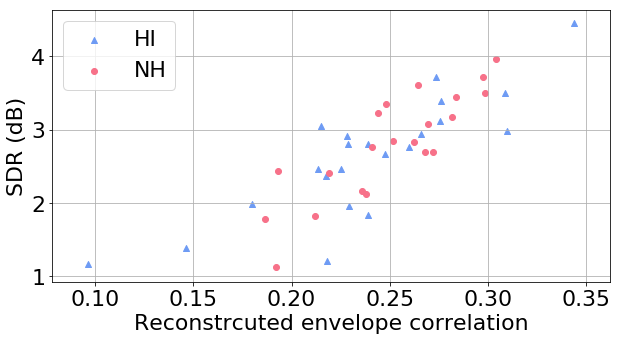

In [34]:
plt.figure(figsize=(10, 5))
sdrs = np.array(list(data_x.groupby(by=["sub_id"])["sdr"].median()))
hi = np.array(list(data_x.groupby(by=["sub_id"])["hi"].mean()))
corrs = np.array(list(data_x.groupby(by=["sub_id"])["corrs"].median()))
plt.scatter(corrs[hi == 1], sdrs[hi == 1], color=pl[7], label="HI", marker='^')
plt.scatter(corrs[hi == 0], sdrs[hi == 0], color=pl[0], label="NH")
plt.legend()
plt.grid()
plt.xlabel("Reconstrcuted envelope correlation")
plt.ylabel("SDR (dB)")
plt.savefig('biss_eeg_all_sub_valid_trials_scatter.pdf', transparent=True, bbox_inches='tight')

In [105]:
data = pd.read_csv('final_evaluation_eeg_sp_vs_sp_with_corrs_v7.csv')
data_raw = data[data['dataset_name'] == 'recon test env']
data_raw = data_raw[data_raw['noise_train'] == 5.0]
data_raw = data_raw[data_raw["causal"] == 1]
data_raw = data_raw[data_raw["sub_id"] == 8]
print(len(data_raw))
print(data_raw)

128
                                            model  nfft  hop  kernel1  \
34688  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34689  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34690  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34691  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34692  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34693  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34694  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34695  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34696  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34697  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34698  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34699  201908052205_ICM_noise_50_40_std_125_sep_C   512  125        3   
34700  201908052205_ICM_noise_50_40_std_125_sep

HI
[[14.2337935]]
NH
[[17.66455373]]


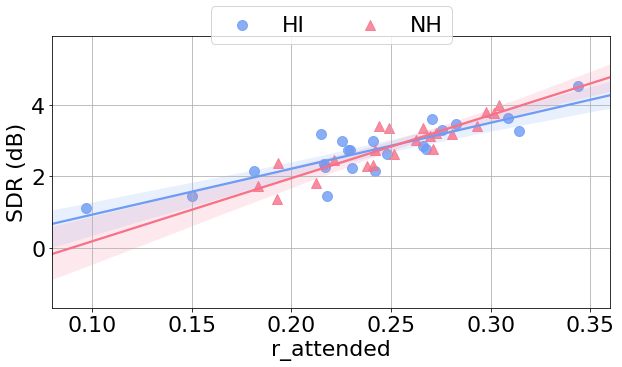

In [114]:
import csv
from sklearn.linear_model import LinearRegression

sdrs = np.array(list(data_x.groupby(by=["sub_id"])["sdr"].median()))
hi = np.array(list(data_x.groupby(by=["sub_id"])["hi"].mean()))
corrs = np.array(list(data_x.groupby(by=["sub_id"])["corrs"].median()))

with open('nh_vs_hi_all_trials.csv', 'w') as csv_file:
    file_writer = csv.writer(csv_file, delimiter=',')
    file_writer.writerow(['sub_id', 'hi', 'sdr', 'corr'])
    
    for k, h, s, c in zip(range(len(hi)), hi, sdrs, corrs):
        file_writer.writerow([k, h, s, c])

data = pd.read_csv('nh_vs_hi_all_trials.csv')   

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.palette = 'Blues'
ax = sns.regplot(data=data[data['hi'] == 1], x='corr', y='sdr', ax=ax, color=pl[7], label='HI', scatter_kws={'s':100})
ax = sns.regplot(data=data[data['hi'] == 0], x='corr', y='sdr', ax=ax, marker='^', color=pl[0], label='NH', scatter_kws={'s':100})

ln = LinearRegression()
ln.fit(np.array(data['corr']).reshape(-1, 1), np.array(data['sdr']).reshape(-1, 1))
print('HI')
print(ln.coef_)

ln = LinearRegression()
ln.fit(np.array(data[data['hi'] == 0]['corr']).reshape(-1, 1), np.array(data[data['hi'] == 0]['sdr']).reshape(-1, 1))
print('NH')
print(ln.coef_)

# plt.scatter(corrs[hi == 1], sdrs[hi == 1], color=pl[7], label="HI", marker='^')
# plt.scatter(corrs[hi == 0], sdrs[hi == 0], color=pl[0], label="NH")
plt.legend()
ax.grid()
ax.set_xlabel("r_attended")
ax.set_ylabel("SDR (dB)")
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
_ = ax.set_xlim([.08, .36])
# plt.savefig('biss_eeg_all_sub_all_trials_scatter.pdf', transparent=True, bbox_inches='tight')

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Non-causal_NH v.s. Non-causal_HI: MWW RankSum two-sided P_val=1.865e-01 U_stat=3.548e+06
Causal_NH v.s. Non-causal_NH: MWW RankSum two-sided P_val=9.300e-01 U_stat=3.253e+06
Causal_NH v.s. Causal_HI: MWW RankSum two-sided P_val=4.508e-01 U_stat=3.394e+06
AxesSubplot(0.125,0.125;0.775x0.755)
hello


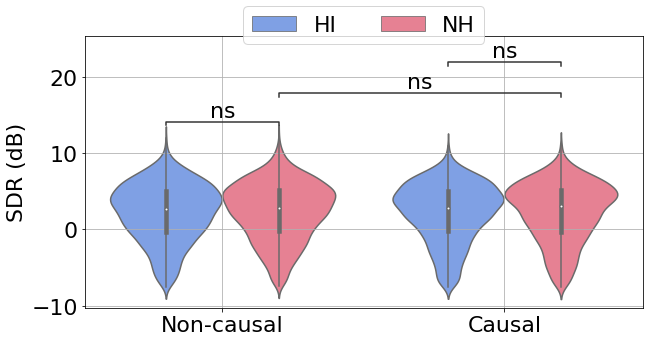

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data_x = data_raw[data_raw['sdr'] > -7.5]
# data_x = data_raw[data_raw["causal"] == 0]
data_x = data_x[data_x['noise_train'] == 5.0]
data_x["cc"] = ["Causal" if a == 1 else "Non-causal" for a in data_x["causal"]]
data_x["hi2"] = ["HI" if a == 1 else "NH" for a in data_x["hi"]]

ll = sns.violinplot(data=data_x, x='cc', y='sdr', hue='hi2', ax=ax, palette=(pl[7], pl[0]))

statannot.add_stat_annotation(ax, data_x, x='cc', y='sdr', hue='hi2', boxPairList=[
                                                (("Non-causal", "NH"), ("Non-causal", "HI")),
                                                (("Causal", "NH"), ("Non-causal", "NH")),
                                                (("Causal", "NH"), ("Causal", "HI")),
                                                
                                            ],
                                test='Mann-Whitney', textFormat='star', loc='inside', verbose=2)

# Select which box you want to change  
print(ll)
print('hello')
for l, k in enumerate(ll.artists):
    print(l)
    print(k)
    if l == 0 or l == 2:
#         mmm = data_x[data_x["sub_id"] == my_order[l]]["sdr"].median()
#         ax[0].text(l-0.3, 15 if l % 2 == 1 else 17, f"{mmm:.2}", color=pl[0], fontsize=15, weight='bold')
        k.set_facecolor(pl[0])  # red - nh
        print('yes')
    else:
#         mmm = data_x[data_x["sub_id"] == my_order[l]]["sdr"].median()
#         ax[0].text(l-0.3, 15 if l % 2 == 1 else 17, f"{mmm:.2}", color=pl[7], fontsize=15, weight='bold')
        k.set_facecolor(pl[7])  # blue hi


ax.grid()
# ax.set_xticklabels(["NI", "HI"])
ax.set_xlabel("")
ax.set_ylabel("SDR (dB)")
ax.legend(title="", loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
# plt.savefig('overall_NH_vs_HI_caus_nc.pdf', bbox_inches='tight', transparent=True)

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: MWW RankSum two-sided P_val=2.693e-01 U_stat=3.850e+06


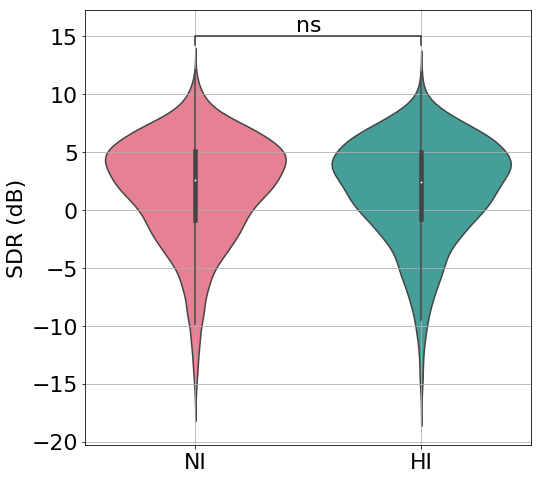

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
data_x = data_raw[data_raw['sdr'] > -7.5]
data_x = data_raw[data_raw["causal"] == 0]
data_x = data_x[data_x['noise_train'] == 5.0]

ll = sns.violinplot(data=data_x, x='hi', y='sdr', ax=ax, palette='husl')

statannot.add_stat_annotation(ax, data_x, x='hi', y='sdr', boxPairList=[(0, 1)],
                                test='Mann-Whitney', textFormat='star', loc='inside', verbose=2)
ax.grid()
ax.set_xticklabels(["NI", "HI"])
ax.set_xlabel("")
ax.set_ylabel("SDR (dB)")
plt.savefig('overall_ns_NH_vs_HI.pdf', bbox_inches='tight', transparent=True)

In [ ]:
data_x = data_raw[data_raw["sub_id"] == 15]
data_x = data_x[data_x["causal"] == 0]
ll = []
for d in data_x.iterrows():
    ll.append(1 if d[1].trial_id in over_corr[d[1].sub_id] else 0)

data_x["valid"] = ll
data_x = data_x[data_x["valid"] == 1]
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='row', sharex='col')

    
xx = ax[0]
# xx.set_ylim(-5, 10)
#     xx.set_xlim(.0, 1.)

a, k = remove_worst(list(data_x[data_x['noise_train'] == 2.0]['sdr']), 0)
b = np.array(list(data_x[data_x['noise_train'] == 2.0]['corrs']))[k] #- data_raw[data_raw['noise_train'] == noises[i]]['corr_f'] 
xx = sns.kdeplot(b, a, cmap="Blues", shade=True, shade_lowest=False, ax=xx)
xx.grid()
xx.set_title("{:.2}".format(np.median(a)))
xx.set_xlabel("")
xx.set_ylabel("")


col = ['tomato', 'orangered', 'seagreen', 'skyblue', 'rebeccapurple', 'gray']


xx = ax[1]
# xx.set_ylim(-5, 10)
#     xx.set_xlim(.0, 1.)

a, k = remove_worst(list(data_x[data_x['noise_train'] == 2.0]['sdr']), 0)
b = np.array(list(data_x[data_x['noise_train'] == 2.0]['corrs']))[k] # - data_raw[data_raw['noise_train'] == noises[i]]['corr_f'] 

lr = LinearRegression().fit(np.array(a).reshape(-1, 1), np.array(b).reshape(-1, 1))
cc = lr.coef_

xx = sns.regplot(b, a, ax=xx, color='skyblue')
xx.grid()
xx.set_xlabel("")
xx.set_ylabel("")
#     xx.set_title("{:.2}/{:.2}".format(cc[0][0], np.median(a)))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
# plt.tight_layout()
# plt.xlabel("Correlation")
# plt.ylabel("SDR (dB)")
# plt.savefig("raw_test_1_noise.pdf")

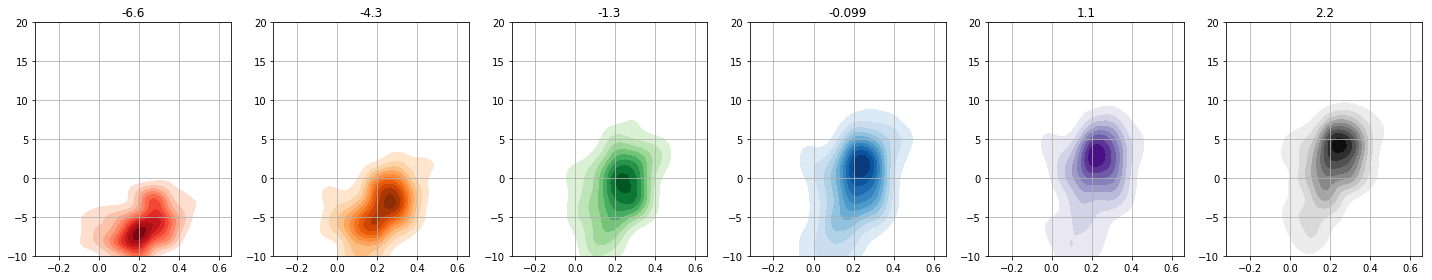

In [28]:
data_x = data_raw[data_raw["sub_id"] == 5]
data_x = data_x[data_x["causal"] == 0]

# ll = []
# for d in data_x.iterrows():
#     ll.append(1 if d[1].trial_id in over_corr[d[1].sub_id] else 0)

# data_x["valid"] = ll
# data_x = data_x[data_x["valid"] == 1]

cmaps = ["Reds", "Oranges", "Greens", "Blues", "Purples", "Greys"] 
noises = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
f, ax = plt.subplots(1, 6, figsize=(20, 4))

for i in range(6):
    
    xx = ax[i % 6]
    xx.set_ylim(-10, 20)
#     xx.set_xlim(.0, 1.)
    
    a, k = remove_worst(list(data_x[data_x['noise_train'] == noises[i]]['sdr']), 0)
    
#     b = data_raw[data_raw['noise_train'] == noises[i]]['corr_t'] - data_raw[data_raw['noise_train'] == noises[i]]['corr_f']  
    b = np.array(list(data_x[data_x['noise_train'] == noises[i]]['corrs']))[k]

    xx = sns.kdeplot(b, a, cmap=cmaps[i % 6], shade=True, shade_lowest=False, ax=xx)
    xx.grid()
    xx.set_title("{:.2}".format(np.median(a)))

plt.tight_layout()

In [ ]:
data_x = data_raw[data_raw["sub_id"] == 13]
data_x = data_x[data_x["causal"] == 0]

cmaps = ["Reds", "Oranges", "Greens", "Blues", "Purples", "Greys"] 
noises = [0.0, 1.0, 2.0, 3.0, 4.5, 5.0]
f, ax = plt.subplots(2, 6, figsize=(20, 8), sharey='row', sharex='col')
for i in range(6):
    
    xx = ax[0][i % 6]
    xx.set_ylim(-10, 20)
#     xx.set_xlim(.0, 1.)
    
    a, k = remove_worst(list(data_x[data_x['noise_train'] == noises[i]]['sdr']), 50)
    b = np.array(list(data_x[data_x['noise_train'] == noises[i]]['corrs']))[k] #- data_raw[data_raw['noise_train'] == noises[i]]['corr_f'] 
    xx = sns.kdeplot(b, a, cmap=cmaps[i % 6], shade=True, shade_lowest=False, ax=xx)
    xx.grid()
    xx.set_title("{:.2}".format(np.median(a)))
    xx.set_xlabel("")
    xx.set_ylabel("")


col = ['tomato', 'orangered', 'seagreen', 'skyblue', 'rebeccapurple', 'gray']
noises = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

for i in range(6):
    
    xx = ax[1][i % 6]
    xx.set_ylim(-10, 20)
#     xx.set_xlim(.0, 1.)
    
    a, k = remove_worst(list(data_x[data_x['noise_train'] == noises[i]]['sdr']), 50)
    b = np.array(list(data_x[data_x['noise_train'] == noises[i]]['corrs']))[k] # - data_raw[data_raw['noise_train'] == noises[i]]['corr_f'] 
    
    lr = LinearRegression().fit(np.array(a).reshape(-1, 1), np.array(b).reshape(-1, 1))
    cc = lr.coef_
    
    xx = sns.regplot(b, a, ax=xx, color=col[i % 6])
    xx.grid()
    xx.set_xlabel("")
    xx.set_ylabel("")
#     xx.set_title("{:.2}/{:.2}".format(cc[0][0], np.median(a)))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
# plt.tight_layout()
# plt.xlabel("Correlation")
# plt.ylabel("SDR (dB)")
# plt.savefig("raw_test_1_noise.pdf")